# Install Independences

In [1]:
!pip install visualkeras 
# !pip install tensorflow-addons # experimented with radam, we decided to go with nadam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 26.8 MB/s eta 0:00:00


In [2]:
# FOR SPLITTING DATASET
# Import os to move, modify and create directory for training set and test set
import os
# Import random to generate randomicaly a number
import random
# Import shutil to move the image 
import shutil

# FOR DATA LOADER 
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# FOR AUXILIARY FUNCTION OF NEURAL NETWORK
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2

# FOR MODELS NEURAL NETWORK
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, PReLU
from keras.backend import clear_session, reset_uids
from keras import backend as K
from keras.optimizers import Nadam, Adam, AdamW

# FOR TRAINING 
from keras.utils import plot_model
import visualkeras


2024-02-08 09:01:42.894258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 09:01:42.894371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 09:01:43.156226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus =list_physical_devices('GPU')
for gpu in gpus: 
    set_memory_growth(gpu, True)

In [4]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Pre-Processing Data: Splitting 

# DataLoader

In [5]:
def data_load(train_dir, validation_dir, image_size, num_batch):
    # Process Data Augmentation
    datagen=ImageDataGenerator(rescale = 1./255,     # Rescaling factor
                               shear_range=0.2,      # Shear Intensity (Shear angle in counter-clockwise direction in degrees) 
                               zoom_range=0.2,       # Range for random zoom.
                               horizontal_flip=True) # Randomly flip inputs horizontally. 
    
    print('------ Loading TRAIN SET -------')
    training_set=datagen.flow_from_directory(train_dir,
                                         target_size=(image_size[0], image_size[1]),
                                         batch_size=num_batch,
                                         class_mode='categorical',
                                         color_mode='rgb')
    
    print('\n\n------ Loading VALIDATION SET ------')
    validation_set=datagen.flow_from_directory(validation_dir,
                                           target_size=(image_size[0], image_size[1]),
                                           batch_size=num_batch,
                                           class_mode='categorical',
                                           color_mode='rgb')
    return training_set, validation_set

# Auxiliary Functions

## Training

In [6]:
def train_model(model, train_set, val_set, early_stopping, pat, num_model, num_epochs):
    # Apply early stop --> to predict overfitting case
    es = None
    if early_stopping == True:
        es = EarlyStopping(monitor='val_loss',
                           mode='min', 
                           patience=pat,
                           restore_best_weights = True,
                           verbose=1
                           )
        # Create a File Pre trained
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[es, ckpt, ReduceLROnPlateau(monitor='val_loss', factor=0.85,
                                                                             patience=5, min_lr=0.001, 
                                                                             mode='min', verbose=1)],
                                      epochs = num_epochs)
        
    else:
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[ckpt, ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                                                         patience=5, min_lr=0.001, 
                                                                         mode='min', verbose=1)],
                                      epochs = num_epochs)

    return history, filepath, es

In [7]:
def eval_model(model, train_set , val_set):
    # Evaluate the Model
    metrics_train = model.evaluate(train_set)
    metrics_val = model.evaluate(val_set)

    print("Train Accuracy = %.4f - Train Loss = %.4f" % (metrics_train[1], metrics_train[0]))
    print("Test Accuracy = %.4f - Test Loss = %.4f" % (metrics_val[1], metrics_val[0]))
    
    print("Train F1-Score = %.4f" % (metrics_train[2]))
    print("Train Precision = %.4f" % (metrics_train[3]))
    print("Train Recall = %.4f" % (metrics_train[4]))
    
    print("Test F1-Score = %.4f" % (metrics_val[2]))
    print("Test Precision = %.4f" % (metrics_val[3]))
    print("Test Recall = %.4f" % (metrics_val[4]))

## Accuracy and Loss Functions

In [8]:
# Define Loss Functions
def loss_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Accuracy Function
def accuracy_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['acc'], color='teal', label='accuracy')
    plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define F1 Function
def F1_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['f1_m'], color='teal', label='F1_score')
    plt.plot(hist.history['val_f1_m'], color='orange', label='val_F1_score')
    fig.suptitle('F1 Score', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Precision Function
def precision_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['precision_m'], color='teal', label='precision_score')
    plt.plot(hist.history['val_precision_m'], color='orange', label='val_precision_score')
    fig.suptitle('Precision', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Recall Function
def recall_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['recall_m'], color='teal', label='recall_score')
    plt.plot(hist.history['val_recall_m'], color='orange', label='val_recall_score')
    fig.suptitle('Recall', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()


def plot_history(hist):
    loss_function(hist)
    accuracy_function(hist)
    F1_function(hist)
    precision_function(hist)
    recall_function(hist)

In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Models

## Model 1 - ReLU

Image with 64 x 64 x 3 

In [10]:
#%% ----- MODEL 1 -----
#defining model
def model_1a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Adam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier


In [11]:
#%% ----- MODEL 1 -----
#defining model
def model_1b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=AdamW(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

In [12]:
#%% ----- MODEL 1 -----
#defining model
def model_1c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Nadam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

## Model 2 - PReLU

In [13]:
#%% ----- MODEL 2 -----
#Defining model
def model_2a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [14]:
#%% ----- MODEL 2 -----
#Defining model
def model_2b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = AdamW(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [15]:
#%% ----- MODEL 2 -----
#Defining model
def model_2c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = Nadam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

## Model 3 - GeLU

In [16]:
#%% ----- MODEL 3 -----
#defining model
def model_3a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Adam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [17]:
#%% ----- MODEL 3 -----
#defining model
def model_3b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=AdamW(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [18]:
#%% ----- MODEL 3 -----
#defining model
def model_3c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Nadam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

# Training

## Paths

In [19]:
train_dir = '/kaggle/input/pictures-for-train-and-valid/datasetNN/train'
test_dir = '/kaggle/input/pictures-for-train-and-valid/datasetNN/validation'

## Training Model 1

In [20]:
img_size1 = (64, 64, 3)
batch_siz1 = 32
num_classes = 151

In [21]:
neuralnetwork_cnn1a = model_1a(img_size1, num_classes= 151)
neuralnetwork_cnn1a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [22]:
neuralnetwork_cnn1b = model_1b(img_size1, num_classes= 151)
neuralnetwork_cnn1b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

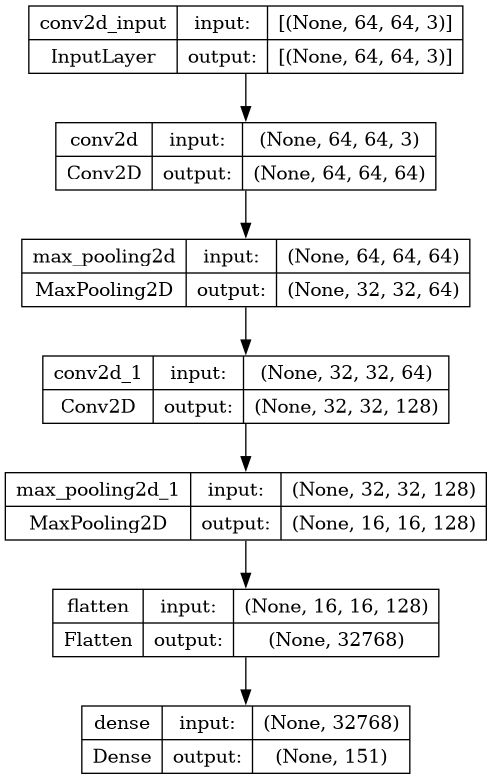

In [23]:
neuralnetwork_cnn1c = model_1c(img_size1, num_classes= 151)
neuralnetwork_cnn1c.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')

#models are all the same, plotting once
plot_model(neuralnetwork_cnn1c, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

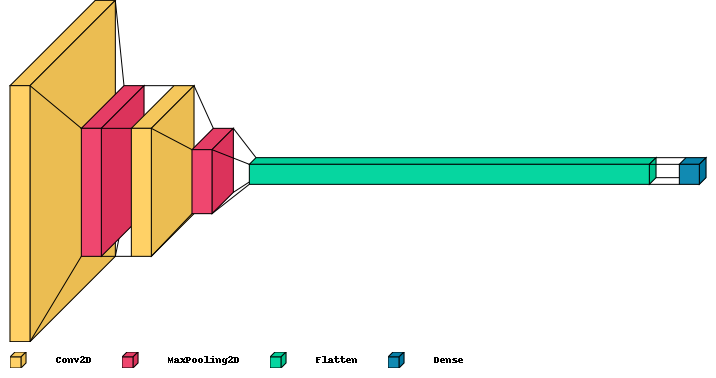

In [24]:
visualkeras.layered_view(neuralnetwork_cnn1c, legend = True, spacing = 30)

In [25]:
train_set1 , val_set1 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size1,
                                  num_batch= batch_siz1)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [26]:
hist1a , fil1a, es1a = train_model(model=neuralnetwork_cnn1a, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=11, 
                                num_epochs= 50) # meglio che arrivi a 30

/tmp/ipykernel_25/1352567975.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/50


I0000 00:00:1707382923.354959      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 [==============================] - ETA: 0s - loss: 4.4156 - acc: 0.1035 - f1_m: 0.0328 - precision_m: 0.2299 - recall_m: 0.0181
Epoch 1: loss improved from inf to 4.41562, saving model to model11.h5
219/219 [==============================] - 71s 308ms/step - loss: 4.4156 - acc: 0.1035 - f1_m: 0.0328 - precision_m: 0.2299 - recall_m: 0.0181 - val_loss: 3.1704 - val_acc: 0.2862 - val_f1_m: 0.1746 - val_precision_m: 0.6139 - val_recall_m: 0.1040 - lr: 0.0015


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
219/219 [==============================] - ETA: 0s - loss: 3.1798 - acc: 0.3036 - f1_m: 0.2205 - precision_m: 0.5802 - recall_m: 0.1409
Epoch 2: loss improved from 4.41562 to 3.17975, saving model to model11.h5
219/219 [==============================] - 43s 196ms/step - loss: 3.1798 - acc: 0.3036 - f1_m: 0.2205 - precision_m: 0.5802 - recall_m: 0.1409 - val_loss: 2.6402 - val_acc: 0.4201 - val_f1_m: 0.3453 - val_precision_m: 0.6669 - val_recall_m: 0.2377 - lr: 0.0015
Epoch 3/50
219/219 [==============================] - ETA: 0s - loss: 2.7257 - acc: 0.4199 - f1_m: 0.3989 - precision_m: 0.6353 - recall_m: 0.2947
Epoch 3: loss improved from 3.17975 to 2.72568, saving model to model11.h5
219/219 [==============================] - 43s 194ms/step - loss: 2.7257 - acc: 0.4199 - f1_m: 0.3989 - precision_m: 0.6353 - recall_m: 0.2947 - val_loss: 2.2460 - val_acc: 0.5112 - val_f1_m: 0.4973 - val_precision_m: 0.6717 - val_recall_m: 0.3980 - lr: 0.0015
Epoch 4/50
219/219 [==============

In [27]:
hist1b , fil1b, es1b = train_model(model=neuralnetwork_cnn1b, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=12, 
                                num_epochs= 50) # meglio che arrivi a 30

/tmp/ipykernel_25/1352567975.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/50
219/219 [==============================] - ETA: 0s - loss: 5.2160 - acc: 0.0568 - f1_m: 0.0105 - precision_m: 0.1168 - recall_m: 0.0056
Epoch 1: loss improved from inf to 5.21603, saving model to model12.h5
219/219 [==============================] - 45s 199ms/step - loss: 5.2160 - acc: 0.0568 - f1_m: 0.0105 - precision_m: 0.1168 - recall_m: 0.0056 - val_loss: 3.8018 - val_acc: 0.1664 - val_f1_m: 0.0383 - val_precision_m: 0.3855 - val_recall_m: 0.0206 - lr: 0.0015
Epoch 2/50
219/219 [==============================] - ETA: 0s - loss: 3.2893 - acc: 0.2812 - f1_m: 0.1998 - precision_m: 0.6037 - recall_m: 0.1261
Epoch 2: loss improved from 5.21603 to 3.28926, saving model to model12.h5
219/219 [==============================] - 43s 198ms/step - loss: 3.2893 - acc: 0.2812 - f1_m: 0.1998 - precision_m: 0.6037 - recall_m: 0.1261 - val_loss: 2.6619 - val_acc: 0.4118 - val_f1_m: 0.3399 - val_precision_m: 0.6556 - val_recall_m: 0.2327 - lr: 0.0015
Epoch 3/50
219/219 [==================

In [28]:
hist1c , fil1c, es1c = train_model(model=neuralnetwork_cnn1c, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=13, 
                                num_epochs= 50) # meglio che arrivi a 30

/tmp/ipykernel_25/1352567975.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/50
219/219 [==============================] - ETA: 0s - loss: 3.9764 - acc: 0.1731 - f1_m: 0.0884 - precision_m: 0.3639 - recall_m: 0.0529
Epoch 1: loss improved from inf to 3.97638, saving model to model13.h5
219/219 [==============================] - 47s 204ms/step - loss: 3.9764 - acc: 0.1731 - f1_m: 0.0884 - precision_m: 0.3639 - recall_m: 0.0529 - val_loss: 2.9957 - val_acc: 0.3369 - val_f1_m: 0.2711 - val_precision_m: 0.6064 - val_recall_m: 0.1772 - lr: 0.0015
Epoch 2/50
219/219 [==============================] - ETA: 0s - loss: 3.0664 - acc: 0.3761 - f1_m: 0.3467 - precision_m: 0.5805 - recall_m: 0.2526
Epoch 2: loss improved from 3.97638 to 3.06644, saving model to model13.h5
219/219 [==============================] - 51s 233ms/step - loss: 3.0664 - acc: 0.3761 - f1_m: 0.3467 - precision_m: 0.5805 - recall_m: 0.2526 - val_loss: 2.5373 - val_acc: 0.4730 - val_f1_m: 0.4615 - val_precision_m: 0.6315 - val_recall_m: 0.3672 - lr: 0.0015
Epoch 3/50
219/219 [==================

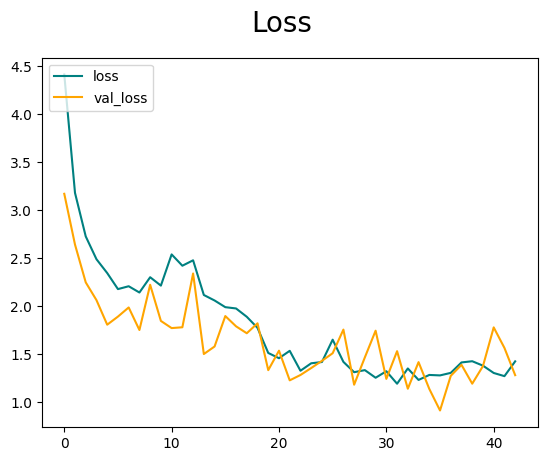

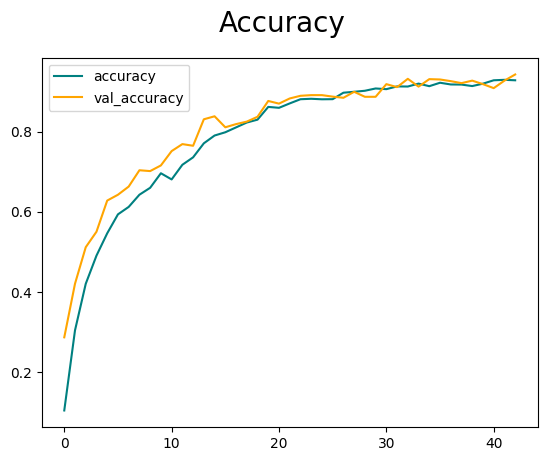

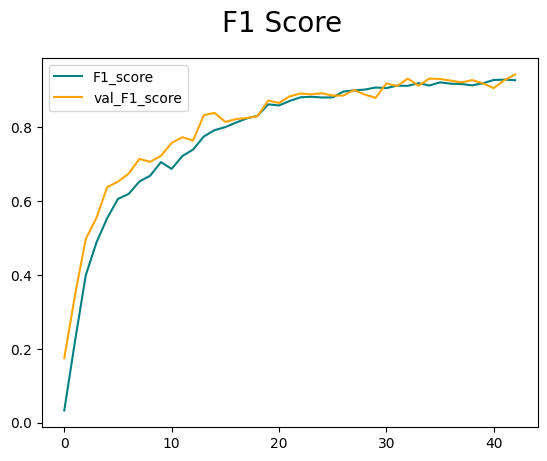

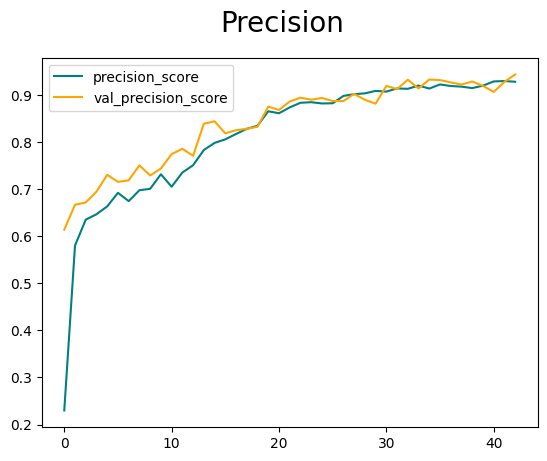

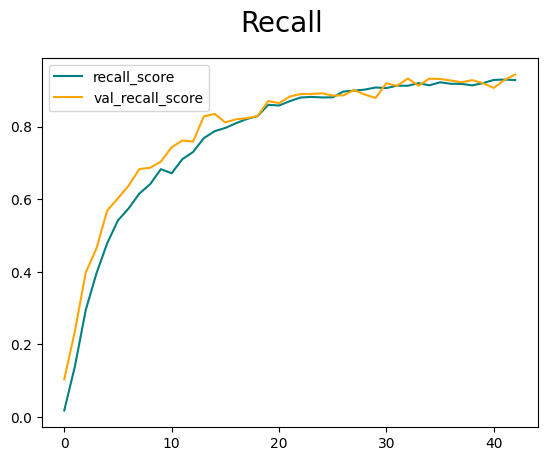

In [29]:
plot_history(hist=hist1a)

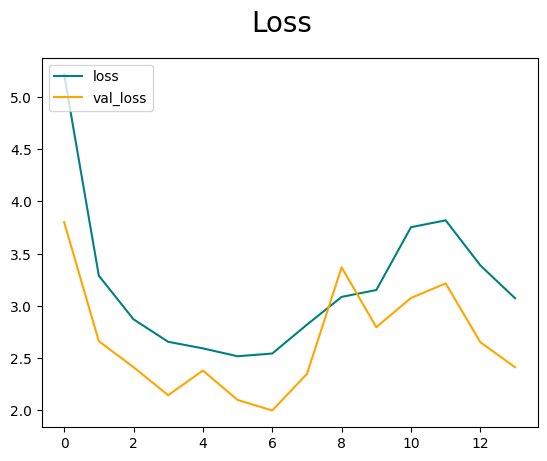

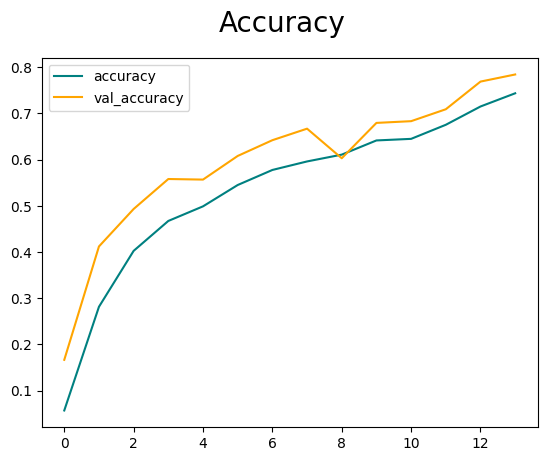

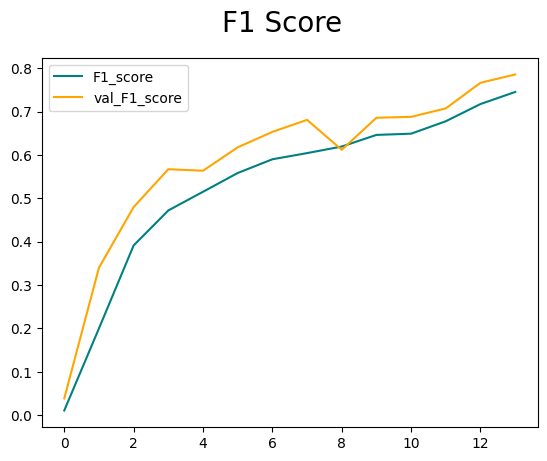

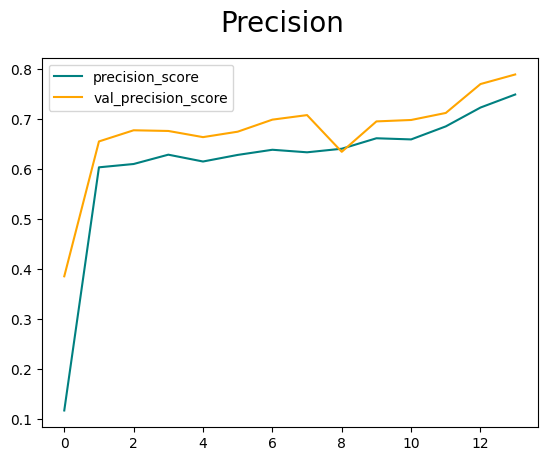

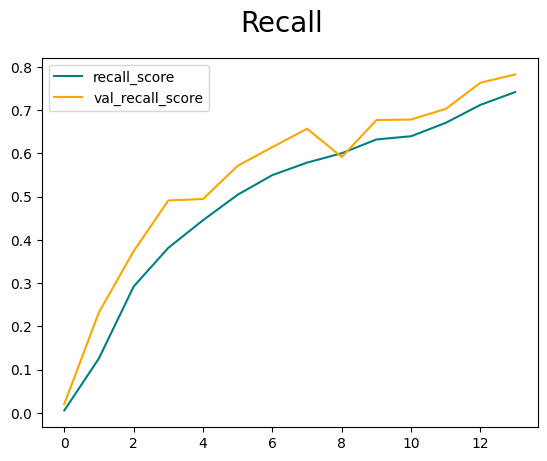

In [30]:
plot_history(hist=hist1b)

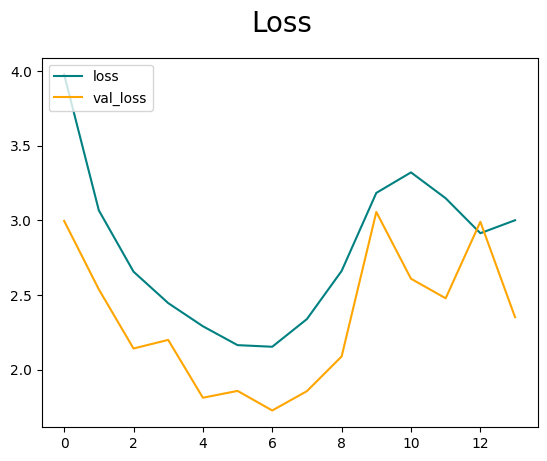

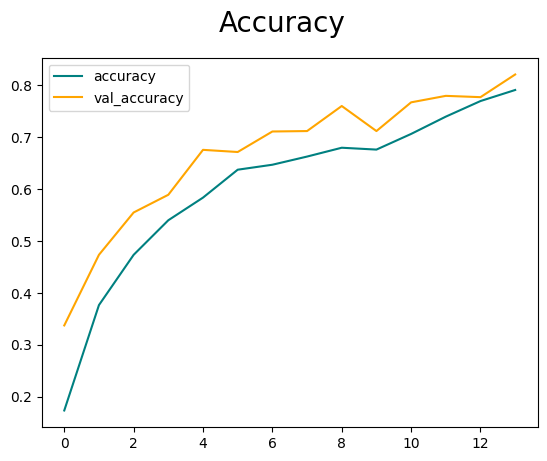

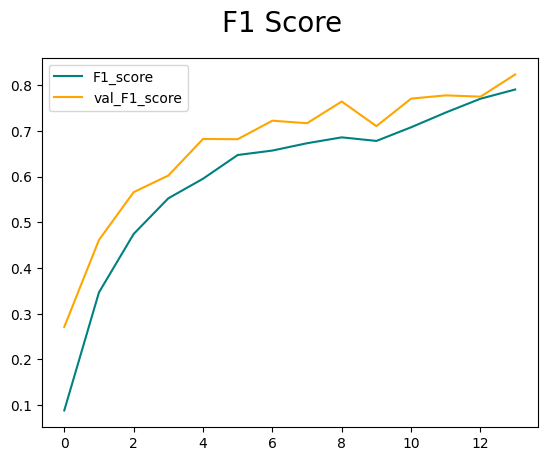

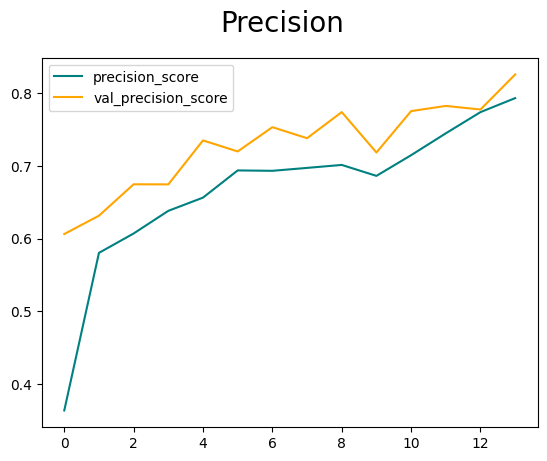

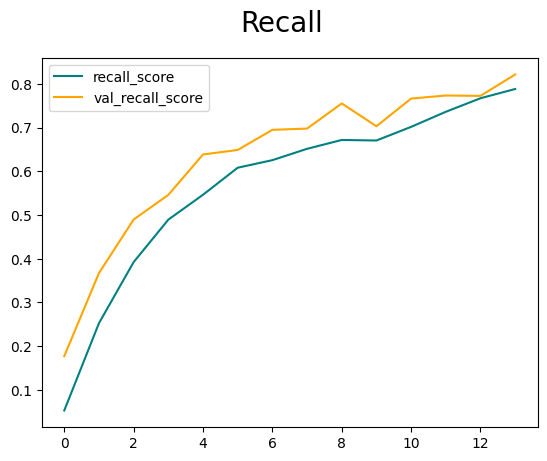

In [31]:
plot_history(hist=hist1c)

## Training Model 2

In [32]:
img_size2 = (64, 64, 3)
batch_siz2 = 32
num_classes = 151

In [33]:
train_set2 , val_set2 = data_load(train_dir = train_dir,
                                validation_dir = test_dir, 
                                image_size=img_size2,
                                num_batch= batch_siz2)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [34]:
#neuralnetwork_cnn2a = model_2a(img_size2, num_classes= 151)
#neuralnetwork_cnn2a.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
#plot_model(neuralnetwork_cnn2a, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [35]:
#neuralnetwork_cnn2b = model_2b(img_size2, num_classes= 151)
#neuralnetwork_cnn2b.summary()

In [36]:
#neuralnetwork_cnn2c = model_2c(img_size2, num_classes= 151)
#neuralnetwork_cnn2c.summary()

In [37]:
#hist2a , fil2a, es2a = train_model(model=neuralnetwork_cnn2a, 
#                                train_set= train_set2, 
#                                val_set= val_set2, 
#                                early_stopping= True,
#                                pat= 7, 
#                                num_model=21, 
#                                num_epochs=50)

In [38]:
#hist2b , fil2b, es2b = train_model(model=neuralnetwork_cnn2b, 
#                                train_set= train_set2, 
#                                val_set= val_set2, 
#                                early_stopping= True,
#                                pat= 7, 
#                                num_model=22, 
#                                num_epochs=50)

In [39]:
#hist2c , fil2c, es2c = train_model(model=neuralnetwork_cnn2c, 
#                                train_set= train_set2, 
#                                val_set= val_set2, 
#                                early_stopping= True,
#                                pat= 7, 
#                                num_model=23, 
#                                num_epochs=50)

In [40]:
#plot_history(hist=hist2a)

In [41]:
#plot_history(hist=hist2b)

In [42]:
#plot_history(hist=hist2c)

## Training Model 3

In [43]:
img_size3= (64, 64, 3)
batch_siz3 = 32
num_classes = 151

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

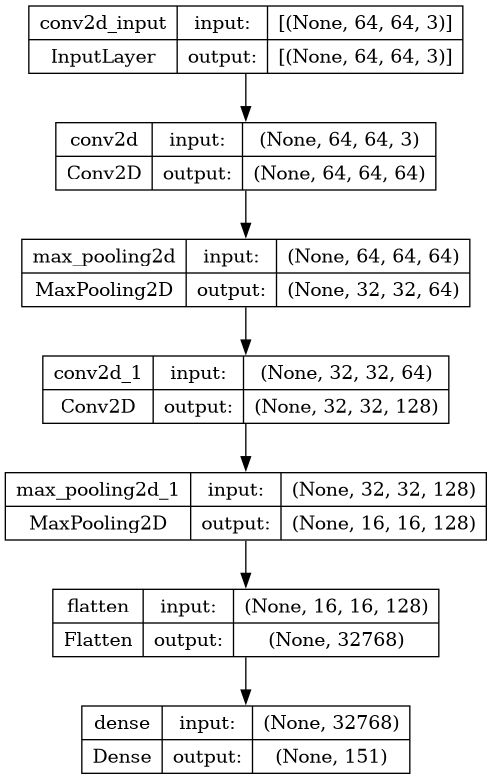

In [44]:
neuralnetwork_cnn3a = model_3a(img_size3, num_classes= 151)
neuralnetwork_cnn3a.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn3a, to_file='model_plot4.png', show_shapes=True, show_layer_names=True)

In [45]:
neuralnetwork_cnn3b = model_3b(img_size3, num_classes= 151)
neuralnetwork_cnn3b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [46]:
neuralnetwork_cnn3c = model_3c(img_size3, num_classes= 151)
neuralnetwork_cnn3c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [47]:
train_set3 , val_set3 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size3,
                                  num_batch= batch_siz3)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [48]:
hist3a , fil3a, es3a = train_model(model=neuralnetwork_cnn3a, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=31, 
                                num_epochs= 50) # meglio che arrivi a 30

Epoch 1/50


/tmp/ipykernel_25/1352567975.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 3.8678 - acc: 0.1724 - f1_m: 0.0812 - precision_m: 0.3775 - recall_m: 0.0475
Epoch 1: loss improved from inf to 3.86784, saving model to model31.h5
219/219 [==============================] - 46s 201ms/step - loss: 3.8678 - acc: 0.1724 - f1_m: 0.0812 - precision_m: 0.3775 - recall_m: 0.0475 - val_loss: 2.7403 - val_acc: 0.3794 - val_f1_m: 0.2511 - val_precision_m: 0.7504 - val_recall_m: 0.1550 - lr: 0.0015
Epoch 2/50


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.6626 - acc: 0.3830 - f1_m: 0.3212 - precision_m: 0.7111 - recall_m: 0.2124
Epoch 2: loss improved from 3.86784 to 2.66261, saving model to model31.h5
219/219 [==============================] - 44s 200ms/step - loss: 2.6626 - acc: 0.3830 - f1_m: 0.3212 - precision_m: 0.7111 - recall_m: 0.2124 - val_loss: 2.0594 - val_acc: 0.5079 - val_f1_m: 0.4549 - val_precision_m: 0.8042 - val_recall_m: 0.3215 - lr: 0.0015
Epoch 3/50
219/219 [==============================] - ETA: 0s - loss: 2.1177 - acc: 0.4975 - f1_m: 0.4766 - precision_m: 0.7486 - recall_m: 0.3546
Epoch 3: loss improved from 2.66261 to 2.11774, saving model to model31.h5
219/219 [==============================] - 44s 201ms/step - loss: 2.1177 - acc: 0.4975 - f1_m: 0.4766 - precision_m: 0.7486 - recall_m: 0.3546 - val_loss: 1.5873 - val_acc: 0.6127 - val_f1_m: 0.5772 - val_precision_m: 0.8442 - val_recall_m: 0.4424 - lr: 0.0015
Epoch 4/50
219/219 [=========================

In [49]:
hist3b , fil3b, es3b = train_model(model=neuralnetwork_cnn3b, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=32, 
                                num_epochs= 50) # meglio che arrivi a 30

Epoch 1/50


/tmp/ipykernel_25/1352567975.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 3.8744 - acc: 0.1806 - f1_m: 0.0863 - precision_m: 0.4046 - recall_m: 0.0505
Epoch 1: loss improved from inf to 3.87443, saving model to model32.h5
219/219 [==============================] - 45s 197ms/step - loss: 3.8744 - acc: 0.1806 - f1_m: 0.0863 - precision_m: 0.4046 - recall_m: 0.0505 - val_loss: 2.9293 - val_acc: 0.3357 - val_f1_m: 0.2453 - val_precision_m: 0.6915 - val_recall_m: 0.1517 - lr: 0.0015
Epoch 2/50
219/219 [==============================] - ETA: 0s - loss: 2.6421 - acc: 0.3927 - f1_m: 0.3299 - precision_m: 0.6991 - recall_m: 0.2195
Epoch 2: loss improved from 3.87443 to 2.64210, saving model to model32.h5
219/219 [==============================] - 43s 197ms/step - loss: 2.6421 - acc: 0.3927 - f1_m: 0.3299 - precision_m: 0.6991 - recall_m: 0.2195 - val_loss: 2.1012 - val_acc: 0.5079 - val_f1_m: 0.4498 - val_precision_m: 0.7918 - val_recall_m: 0.3191 - lr: 0.0015
Epoch 3/50
219/219 [=============================

In [50]:
hist3c , fil3c, es3c = train_model(model=neuralnetwork_cnn3c, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=33, 
                                num_epochs= 50) # meglio che arrivi a 30

/tmp/ipykernel_25/1352567975.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/50
219/219 [==============================] - ETA: 0s - loss: 3.7070 - acc: 0.2007 - f1_m: 0.0974 - precision_m: 0.4403 - recall_m: 0.0565
Epoch 1: loss improved from inf to 3.70699, saving model to model33.h5
219/219 [==============================] - 45s 198ms/step - loss: 3.7070 - acc: 0.2007 - f1_m: 0.0974 - precision_m: 0.4403 - recall_m: 0.0565 - val_loss: 2.5588 - val_acc: 0.4218 - val_f1_m: 0.2850 - val_precision_m: 0.7764 - val_recall_m: 0.1776 - lr: 0.0015
Epoch 2/50
219/219 [==============================] - ETA: 0s - loss: 2.4864 - acc: 0.4356 - f1_m: 0.3578 - precision_m: 0.7209 - recall_m: 0.2426
Epoch 2: loss improved from 3.70699 to 2.48639, saving model to model33.h5
219/219 [==============================] - 45s 206ms/step - loss: 2.4864 - acc: 0.4356 - f1_m: 0.3578 - precision_m: 0.7209 - recall_m: 0.2426 - val_loss: 1.9012 - val_acc: 0.5399 - val_f1_m: 0.4853 - val_precision_m: 0.8298 - val_recall_m: 0.3475 - lr: 0.0015
Epoch 3/50
219/219 [==================

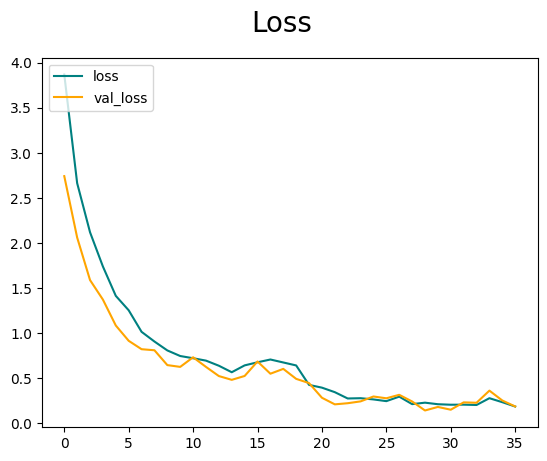

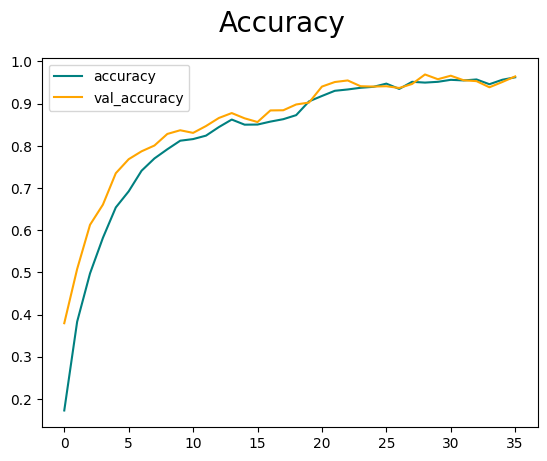

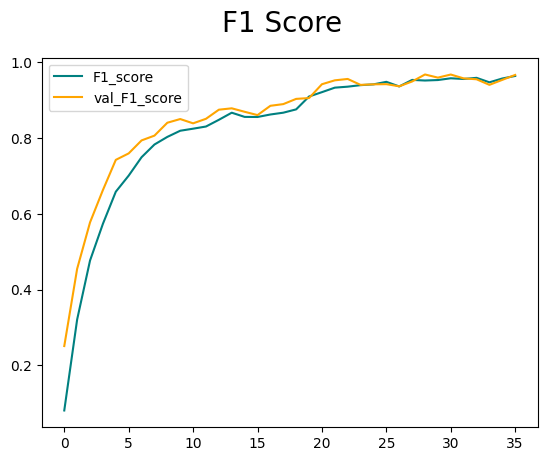

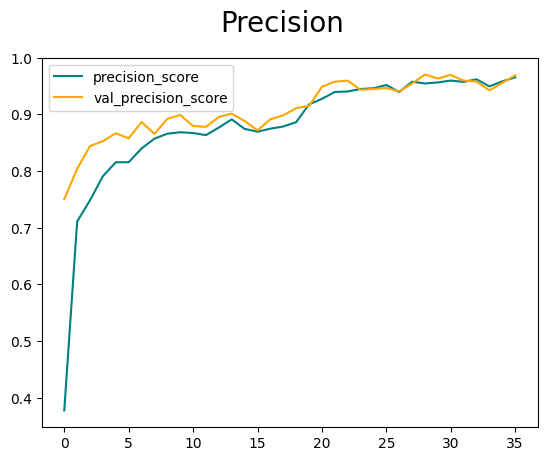

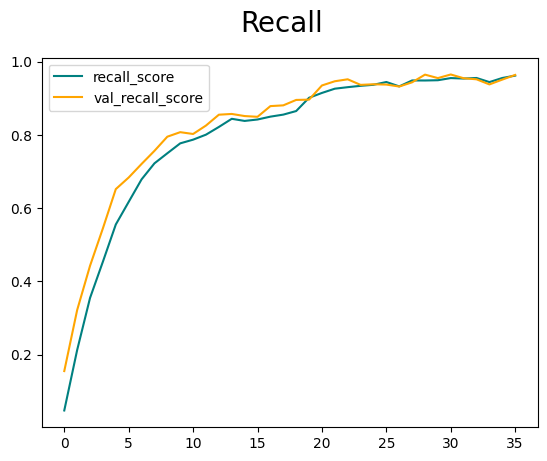

In [51]:
plot_history(hist=hist3a)

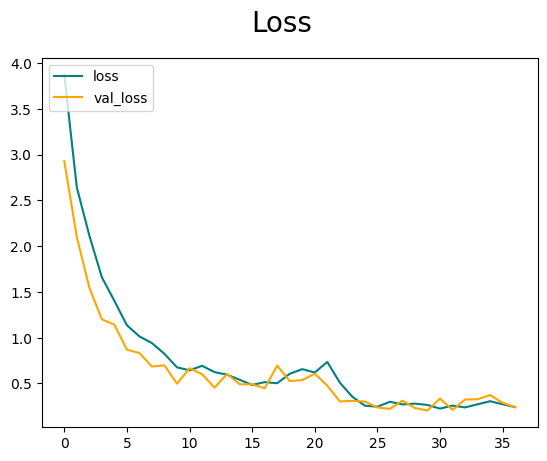

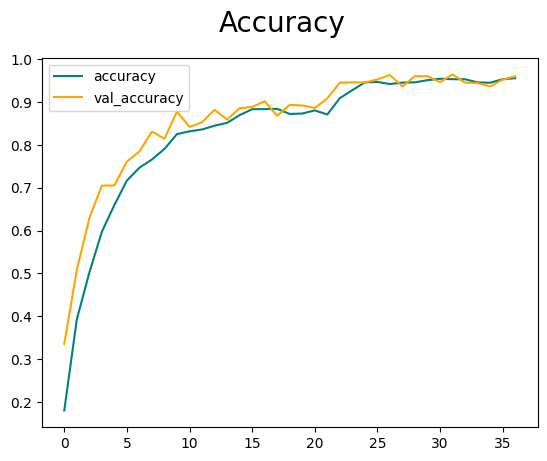

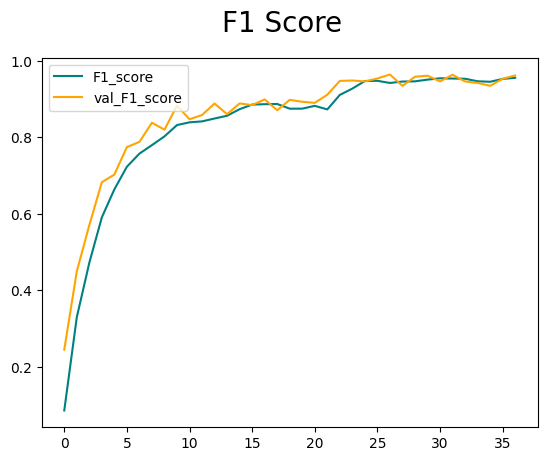

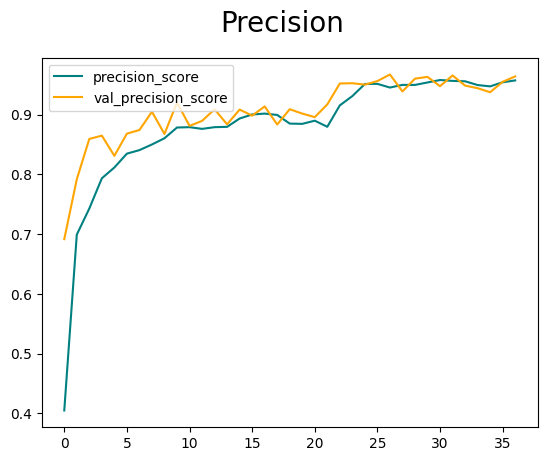

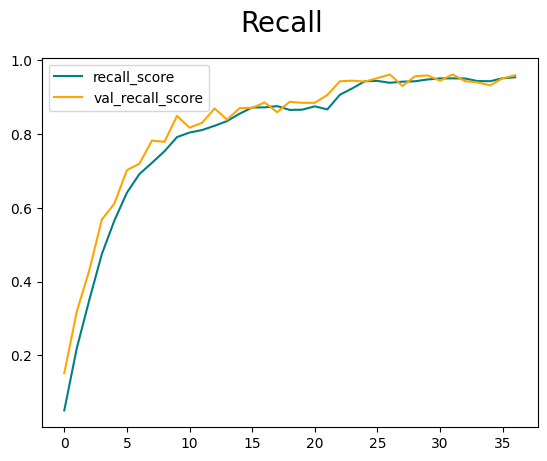

In [52]:
plot_history(hist=hist3b)

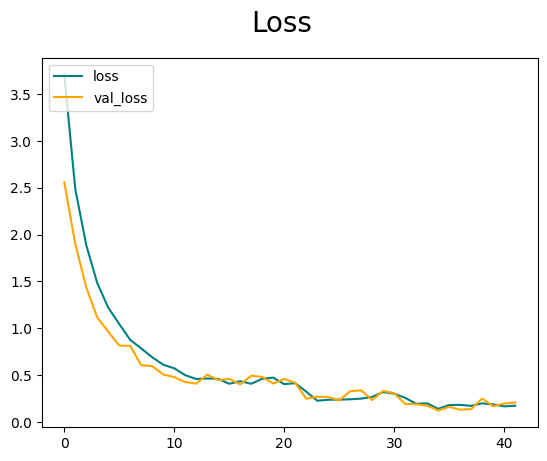

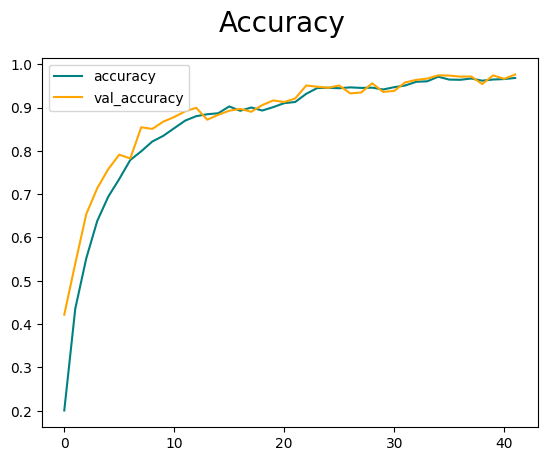

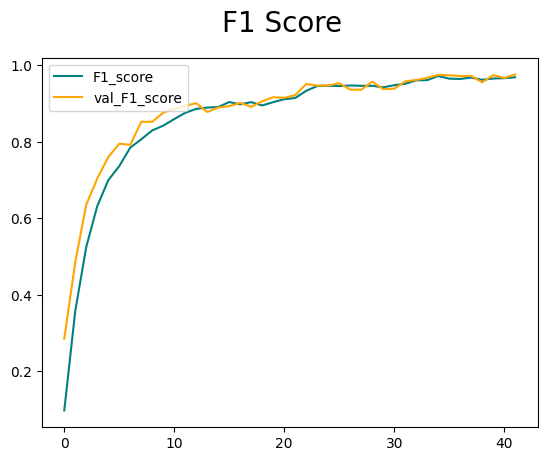

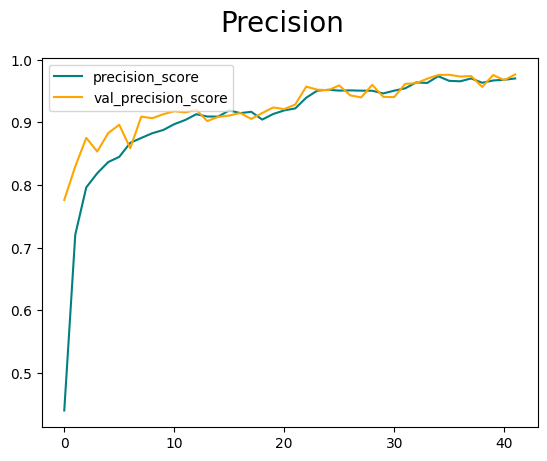

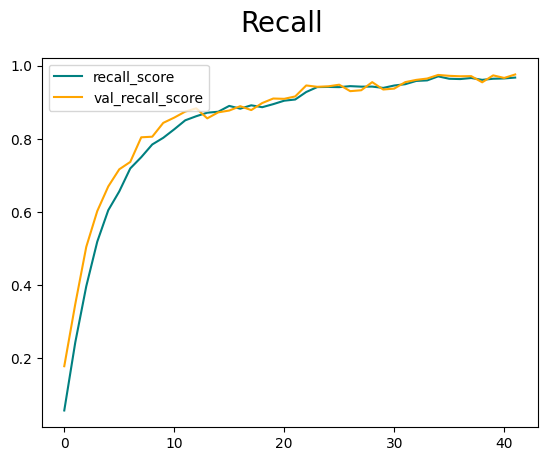

In [53]:
plot_history(hist=hist3c)